Episode 1, Total Reward: -311495.00
Episode 2, Total Reward: -691570.00
Episode 3, Total Reward: -706140.00
Episode 4, Total Reward: -694350.00


C:\Users\kriti\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


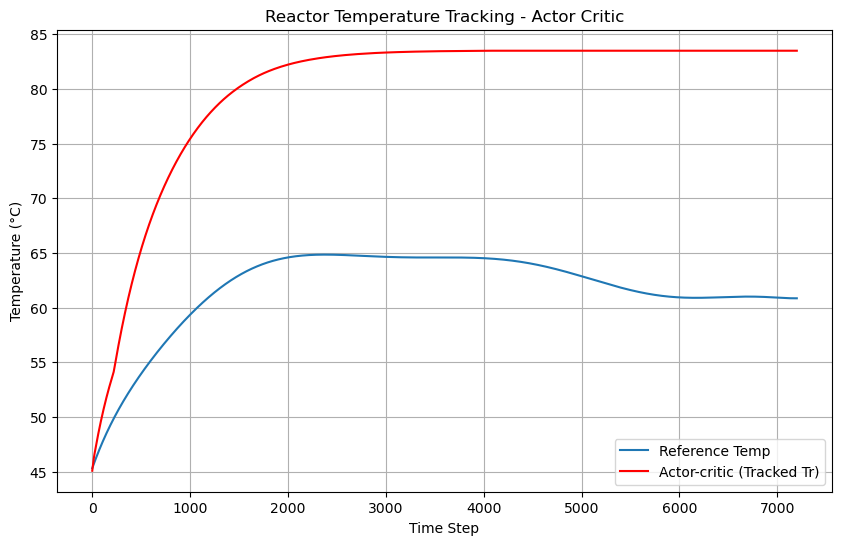

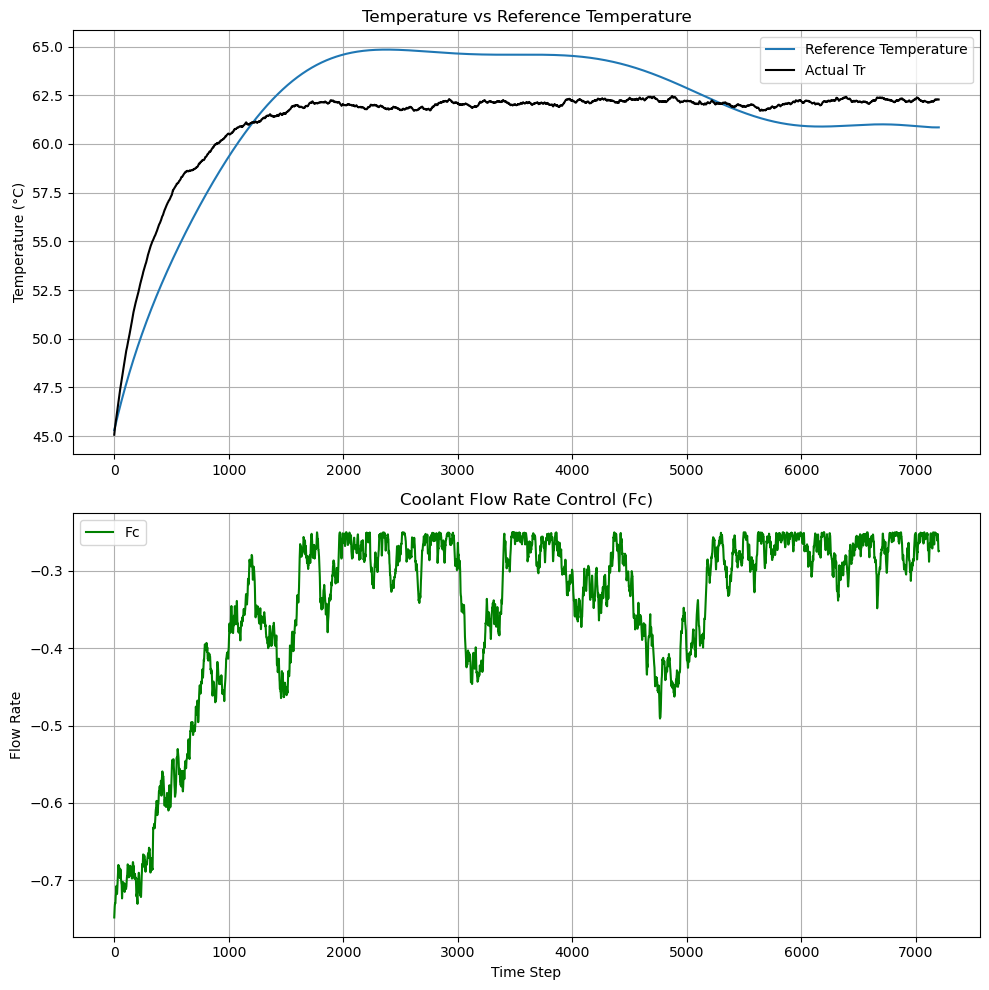

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import gym
from gym import spaces
import csv
from scipy.ndimage import gaussian_filter1d
import torch
import torch.nn as nn
import torch.optim as optim

# Load reactor temperature trajectory from CSV
df = pd.read_csv(r"C:\Users\kriti\Downloads\Trajectory2.csv")
time_steps = np.arange(len(df))

# Extract reference trajectory (ensure correct column name)
try:
    reference_temp = df["x_Traject"]
except KeyError:
    reference_temp = df.iloc[:, 0]  # fallback to first column if name is unknown

# Define batch reactor model
def br(x, t, u, Ad, heater):
    F = u * 16.667
    Ii, M, Tr, Tj = x
    Ri = Ad * Ii * (np.exp(-140.06e3 / (8.3145 * (Tr + 273.15))))
    Rp = (1.7e11 / 60) * (Ii ** 0.5) * (M ** 1.25) * np.exp(-16.9e3 / (0.239 * 8.3145 * (Tr + 273.15)))
    mrCpr = 450 * 4.184 + Ii * 187 * 0.5 + M * 110.58 * 0.5 + (0.7034 - M) * 84.95 * 0.5 + 220 * 0.49 + 7900 * 0.49
    Qpr = 1.212827 * (Tr - 27) ** 0.000267 + heater

    dy1_dt = -Ri
    dy2_dt = -Rp
    dy3_dt = (Rp * 0.5 * -82.2e3 - 33.3083 * (Tr - Tj) + 650 + 12.41e-2 - Qpr) / mrCpr
    dy4_dt = (33.3083 * (Tr - Tj) - F * 4.184 * (Tj - 27)) / ((18 * 4.184) + (240 * 0.49))

    return [dy1_dt, dy2_dt, dy3_dt, dy4_dt]

# Define Gym environment
class BR3(gym.Env):
    def __init__(self):
        self.action_space = spaces.Box(low=np.array([0.25, 0]), high=np.array([0.75, 100]), shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)
        self.t = np.linspace(0, 7200, len(reference_temp))
        self.i = 0

        self.a1 = reference_temp.values.tolist()
        self.sp = self.a1[self.i]
        self.I, self.M, self.Tr, self.Tj = 4.5e-3, 0.7034, 45.0, 40.0
        self.state = (self.Tr, self.sp)
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])
        self.time_step = 7200

        # Clear existing data.csv file
        with open('data.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['Setpoint', 'Tr', 'Tj', 'u', 'heater'])

    def step(self, action):
        u, heater = action

        if self.i >= len(self.t) - 1:
            return (self.Tr, self.sp), -100, True, {}

        ts = [self.t[self.i], self.t[self.i + 1]]
        y = scipy.integrate.odeint(br, self.y0, ts, args=(u, 4.4e16, heater))
        x = np.round(y, decimals=4)

        self.I, self.M, self.Tr, self.Tj = x[-1]
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])

        data = [self.sp, self.Tr, self.Tj, u, heater]
        with open('data.csv', 'a') as file:
            writer = csv.writer(file)
            writer.writerow(data)

        self.i += 1
        if self.i < len(self.a1):
            self.sp = self.a1[self.i]

        error = abs(self.sp - self.Tr)
        if error <= 0.5:
            reward = 100
        elif error <= 1:
            reward = 50
        elif error <= 3:
            reward = 25
        elif error <= 4:
            reward = 10
        else:
            reward = -100

        return (self.Tr, self.sp), reward, self.i >= len(self.t) - 1, {}

    def reset(self):
        self.I, self.M, self.Tr, self.Tj = 4.5e-3, 0.7034, 45.0, 40.0
        self.i = 0
        self.sp = self.a1[self.i]
        self.state = (self.Tr, self.sp)
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])
        return self.state

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid(),  # Output between 0 and 1
        )

    def forward(self, state):
        return self.net(state)


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, state):
        return self.net(state)

state_dim = 2
action_dim = 2

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=0.0005)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

gamma = 0.99
num_episodes = 4

episode_rewards = []
final_Tr = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    Tr_track = []

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = actor(state_tensor).detach().numpy()[0]

        # Scale action: Fc in [0.25, 0.75], heater in [0, 100]
        action[0] = action[0] * 0.5 + 0.25
        action[1] = action[1] * 100

        next_state, reward, done, _ = env.step(action)

        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        reward_tensor = torch.tensor([[reward]], dtype=torch.float)

        # Critic loss
        value = critic(state_tensor)
        next_value = critic(next_state_tensor)
        target = reward_tensor + gamma * next_value * (1 - int(done))
        critic_loss = nn.MSELoss()(value, target.detach())

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Actor loss
        advantage = (target - value).detach()
        log_prob = -((actor(state_tensor) - torch.tensor(action)).pow(2)).sum()  # simple surrogate
        actor_loss = -log_prob * advantage

        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        state = next_state
        total_reward += reward
        Tr_track.append(state[0])

    episode_rewards.append(total_reward)
    final_Tr.append(Tr_track)

    print(f"Episode {episode + 1}, Total Reward: {total_reward:.2f}")
    
# Instantiate environment
env = BR3()
state = env.reset()

# Initialize arrays

Fc_values = []
heater_values = []
Tr_values = []

np.random.seed(1)
Fc = 1

        
for i in range(len(time_steps)):
    noise = np.random.normal(0, 0.006)
    Fc *= 0.999
    Fc += noise
    Fc = np.clip(Fc, 0.25, 0.75)
    Fc_values.append(Fc)
    action = env.action_space.sample()  # Random action
    state, _, done, _ = env.step(action)
    
    
    heater = action[1]
    
    
    
    heater_values.append(heater)
    Tr_values.append(state[0])
    
    if done:
        break

# Convert to NumPy arrays
Fc_values = np.array(Fc_values)
heater_values = np.array(heater_values)
Tr_values = np.array(Tr_values)

# Smooth values
Fc_values_smoothed = gaussian_filter1d(Fc_values, sigma=1)
heater_smoothed = gaussian_filter1d(heater_values, sigma=5)
F_mirrored = -Fc_values_smoothed

plt.figure(figsize=(10, 6))
plt.plot(reference_temp.values[:len(final_Tr[-1])], label="Reference Temp")
plt.plot(final_Tr[-1], label="Actor-critic (Tracked Tr)",color="red")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Reactor Temperature Tracking - Actor Critic")
plt.legend()
plt.grid(True)
plt.show()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Reactor temperature vs reference
ax1.set_title("Temperature vs Reference Temperature")
ax1.plot(time_steps[:len(reference_temp)], reference_temp, label="Reference Temperature", color="tab:blue")
ax1.plot(time_steps[:len(Tr_values)], Tr_values, label="Actual Tr", color="black")
ax1.set_ylabel("Temperature (°C)")
ax1.legend()
ax1.grid(True)

# Coolant Flow Rate
ax2.set_title("Coolant Flow Rate Control (Fc)")

ax2.plot(time_steps[:len(F_mirrored)], F_mirrored, label="Fc", color="green")
ax2.set_ylabel("Flow Rate")
ax2.set_xlabel("Time Step")
ax2.legend()
ax2.grid(True)


plt.tight_layout()
plt.show()



Episode 1, Total Reward: -580770.00
Episode 2, Total Reward: -611540.00
Episode 3, Total Reward: -673115.00


C:\Users\kriti\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


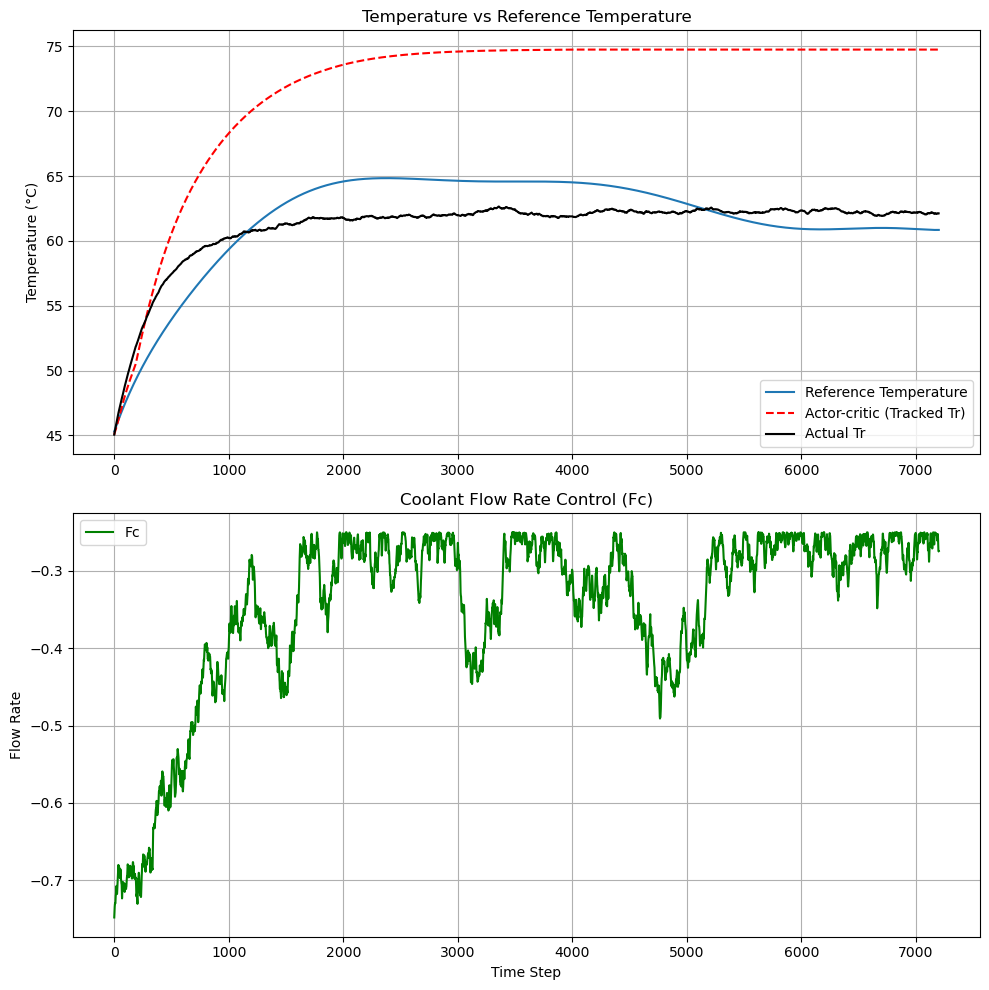

In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import gym
from gym import spaces
import csv
from scipy.ndimage import gaussian_filter1d
import torch
import torch.nn as nn
import torch.optim as optim

# Load reactor temperature trajectory from CSV
df = pd.read_csv(r"C:\Users\kriti\Downloads\Trajectory2.csv")
time_steps = np.arange(len(df))

# Extract reference trajectory (ensure correct column name)
try:
    reference_temp = df["x_Traject"]
except KeyError:
    reference_temp = df.iloc[:, 0]  # fallback to first column if name is unknown

# Define batch reactor model
def br(x, t, u, Ad, heater):
    F = u * 16.667
    Ii, M, Tr, Tj = x
    Ri = Ad * Ii * (np.exp(-140.06e3 / (8.3145 * (Tr + 273.15))))
    Rp = (1.7e11 / 60) * (Ii ** 0.5) * (M ** 1.25) * np.exp(-16.9e3 / (0.239 * 8.3145 * (Tr + 273.15)))
    mrCpr = 450 * 4.184 + Ii * 187 * 0.5 + M * 110.58 * 0.5 + (0.7034 - M) * 84.95 * 0.5 + 220 * 0.49 + 7900 * 0.49
    Qpr = 1.212827 * (Tr - 27) ** 0.000267 + heater

    dy1_dt = -Ri
    dy2_dt = -Rp
    dy3_dt = (Rp * 0.5 * -82.2e3 - 33.3083 * (Tr - Tj) + 650 + 12.41e-2 - Qpr) / mrCpr
    dy4_dt = (33.3083 * (Tr - Tj) - F * 4.184 * (Tj - 27)) / ((18 * 4.184) + (240 * 0.49))

    return [dy1_dt, dy2_dt, dy3_dt, dy4_dt]

# Define Gym environment
class BR3(gym.Env):
    def __init__(self):
        self.action_space = spaces.Box(low=np.array([0.25, 0]), high=np.array([0.75, 100]), shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)
        self.t = np.linspace(0, 7200, len(reference_temp))
        self.i = 0

        self.a1 = reference_temp.values.tolist()
        self.sp = self.a1[self.i]
        self.I, self.M, self.Tr, self.Tj = 4.5e-3, 0.7034, 45.0, 40.0
        self.state = (self.Tr, self.sp)
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])
        self.time_step = 7200

        # Clear existing data.csv file
        with open('data.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['Setpoint', 'Tr', 'Tj', 'u', 'heater'])

    def step(self, action):
        u, heater = action

        if self.i >= len(self.t) - 1:
            return (self.Tr, self.sp), -100, True, {}

        ts = [self.t[self.i], self.t[self.i + 1]]
        y = scipy.integrate.odeint(br, self.y0, ts, args=(u, 4.4e16, heater))
        x = np.round(y, decimals=4)

        self.I, self.M, self.Tr, self.Tj = x[-1]
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])

        data = [self.sp, self.Tr, self.Tj, u, heater]
        with open('data.csv', 'a') as file:
            writer = csv.writer(file)
            writer.writerow(data)

        self.i += 1
        if self.i < len(self.a1):
            self.sp = self.a1[self.i]

        error = abs(self.sp - self.Tr)
        if error <= 0.5:
            reward = 100
        elif error <= 1:
            reward = 50
        elif error <= 3:
            reward = 25
        elif error <= 4:
            reward = 10
        else:
            reward = -100

        return (self.Tr, self.sp), reward, self.i >= len(self.t) - 1, {}

    def reset(self):
        self.I, self.M, self.Tr, self.Tj = 4.5e-3, 0.7034, 45.0, 40.0
        self.i = 0
        self.sp = self.a1[self.i]
        self.state = (self.Tr, self.sp)
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])
        return self.state

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid(),  # Output between 0 and 1
        )

    def forward(self, state):
        return self.net(state)


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, state):
        return self.net(state)

state_dim = 2
action_dim = 2

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=0.0005)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

gamma = 0.91
num_episodes = 3

episode_rewards = []
final_Tr = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    Tr_track = []

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = actor(state_tensor).detach().numpy()[0]

        # Scale action: Fc in [0.25, 0.75], heater in [0, 100]
        action[0] = action[0] * 0.5 + 0.25
        action[1] = action[1] * 100

        next_state, reward, done, _ = env.step(action)

        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        reward_tensor = torch.tensor([[reward]], dtype=torch.float)

        # Critic loss
        value = critic(state_tensor)
        next_value = critic(next_state_tensor)
        target = reward_tensor + gamma * next_value * (1 - int(done))
        critic_loss = nn.MSELoss()(value, target.detach())

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Actor loss
        advantage = (target - value).detach()
        log_prob = -((actor(state_tensor) - torch.tensor(action)).pow(2)).sum()  # simple surrogate
        actor_loss = -log_prob * advantage

        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        state = next_state
        total_reward += reward
        Tr_track.append(state[0])

    episode_rewards.append(total_reward)
    final_Tr.append(Tr_track)

    print(f"Episode {episode + 1}, Total Reward: {total_reward:.2f}")
    
# Instantiate environment
env = BR3()
state = env.reset()

# Initialize arrays

Fc_values = []
heater_values = []
Tr_values = []

np.random.seed(1)
Fc = 1

        
for i in range(len(time_steps)):
    noise = np.random.normal(0, 0.006)
    Fc *= 0.999
    Fc += noise
    Fc = np.clip(Fc, 0.25, 0.75)
    Fc_values.append(Fc)
    action = env.action_space.sample()  # Random action
    state, _, done, _ = env.step(action)
    
    
    heater = action[1]
    
    
    
    heater_values.append(heater)
    Tr_values.append(state[0])
    
    if done:
        break

# Convert to NumPy arrays
Fc_values = np.array(Fc_values)
heater_values = np.array(heater_values)
Tr_values = np.array(Tr_values)

# Smooth values
Fc_values_smoothed = gaussian_filter1d(Fc_values, sigma=1)
heater_smoothed = gaussian_filter1d(heater_values, sigma=5)
F_mirrored = -Fc_values_smoothed


# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Reactor temperature vs reference
ax1.set_title("Temperature vs Reference Temperature")
ax1.plot(time_steps[:len(reference_temp)], reference_temp, label="Reference Temperature", color="tab:blue")
ax1.plot(final_Tr[-1], label="Actor-critic (Tracked Tr)",linestyle="dashed",color="red")
ax1.plot(time_steps[:len(Tr_values)], Tr_values, label="Actual Tr", color="black")
ax1.set_ylabel("Temperature (°C)")
ax1.legend()
ax1.grid(True)

# Coolant Flow Rate
ax2.set_title("Coolant Flow Rate Control (Fc)")

ax2.plot(time_steps[:len(F_mirrored)], F_mirrored, label="Fc", color="green")
ax2.set_ylabel("Flow Rate")
ax2.set_xlabel("Time Step")
ax2.legend()
ax2.grid(True)




plt.tight_layout()
plt.show()






Episode 1, Total Reward: -655590.00
Episode 2, Total Reward: -278105.00
Episode 3, Total Reward: -267970.00


C:\Users\kriti\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


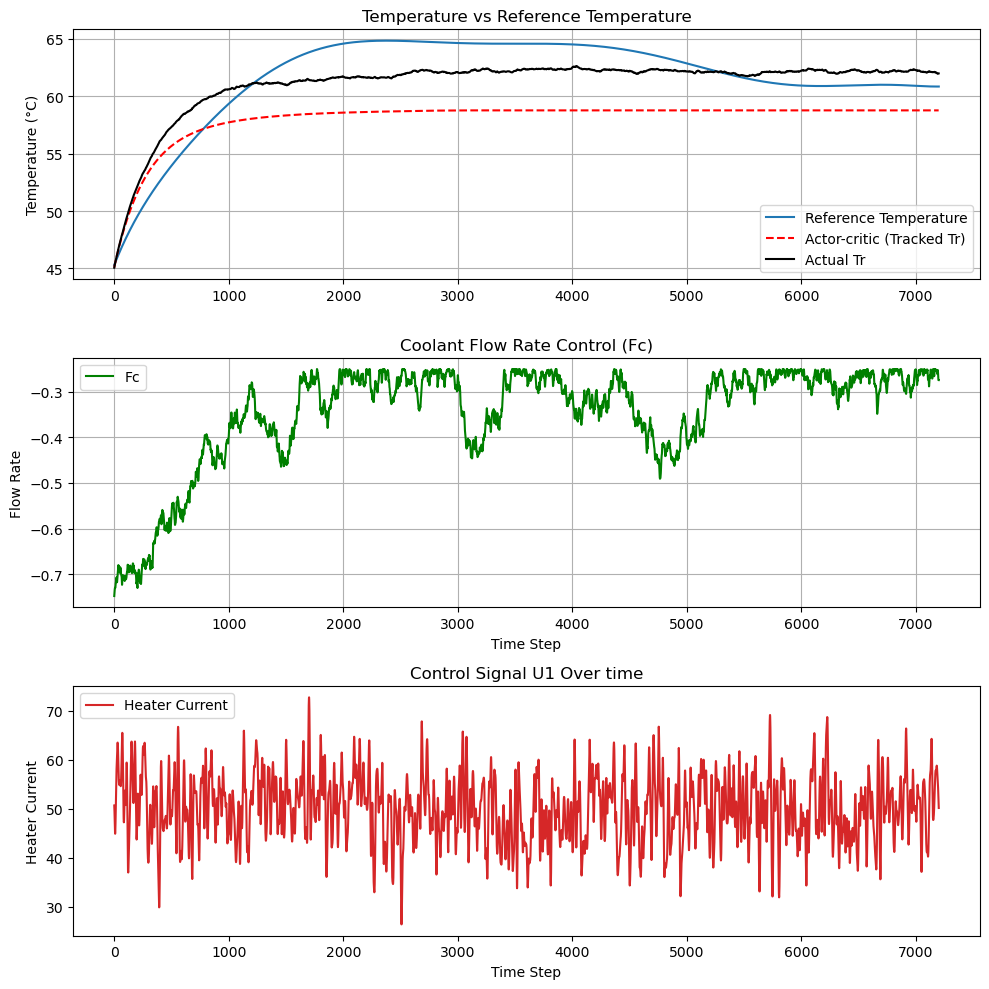

In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import gym
from gym import spaces
import csv
from scipy.ndimage import gaussian_filter1d
import torch
import torch.nn as nn
import torch.optim as optim

# Load reactor temperature trajectory from CSV
df = pd.read_csv(r"C:\Users\kriti\Downloads\Trajectory2.csv")
time_steps = np.arange(len(df))

# Extract reference trajectory (ensure correct column name)
try:
    reference_temp = df["x_Traject"]
except KeyError:
    reference_temp = df.iloc[:, 0]  # fallback to first column if name is unknown

# Define batch reactor model
def br(x, t, u, Ad, heater):
    F = u * 16.667
    Ii, M, Tr, Tj = x
    Ri = Ad * Ii * (np.exp(-140.06e3 / (8.3145 * (Tr + 273.15))))
    Rp = (1.7e11 / 60) * (Ii ** 0.5) * (M ** 1.25) * np.exp(-16.9e3 / (0.239 * 8.3145 * (Tr + 273.15)))
    mrCpr = 450 * 4.184 + Ii * 187 * 0.5 + M * 110.58 * 0.5 + (0.7034 - M) * 84.95 * 0.5 + 220 * 0.49 + 7900 * 0.49
    Qpr = 1.212827 * (Tr - 27) ** 0.000267 + heater

    dy1_dt = -Ri
    dy2_dt = -Rp
    dy3_dt = (Rp * 0.5 * -82.2e3 - 33.3083 * (Tr - Tj) + 650 + 12.41e-2 - Qpr) / mrCpr
    dy4_dt = (33.3083 * (Tr - Tj) - F * 4.184 * (Tj - 27)) / ((18 * 4.184) + (240 * 0.49))

    return [dy1_dt, dy2_dt, dy3_dt, dy4_dt]

# Define Gym environment
class BR3(gym.Env):
    def __init__(self):
        self.action_space = spaces.Box(low=np.array([0.25, 0]), high=np.array([0.75, 100]), shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)
        self.t = np.linspace(0, 7200, len(reference_temp))
        self.i = 0

        self.a1 = reference_temp.values.tolist()
        self.sp = self.a1[self.i]
        self.I, self.M, self.Tr, self.Tj = 4.5e-3, 0.7034, 45.0, 40.0
        self.state = (self.Tr, self.sp)
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])
        self.time_step = 7200

        # Clear existing data.csv file
        with open('data.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['Setpoint', 'Tr', 'Tj', 'u', 'heater'])

    def step(self, action):
        u, heater = action

        if self.i >= len(self.t) - 1:
            return (self.Tr, self.sp), -100, True, {}

        ts = [self.t[self.i], self.t[self.i + 1]]
        y = scipy.integrate.odeint(br, self.y0, ts, args=(u, 4.4e16, heater))
        x = np.round(y, decimals=4)

        self.I, self.M, self.Tr, self.Tj = x[-1]
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])

        data = [self.sp, self.Tr, self.Tj, u, heater]
        with open('data.csv', 'a') as file:
            writer = csv.writer(file)
            writer.writerow(data)

        self.i += 1
        if self.i < len(self.a1):
            self.sp = self.a1[self.i]

        error = abs(self.sp - self.Tr)
        if error <= 0.5:
            reward = 100
        elif error <= 1:
            reward = 50
        elif error <= 3:
            reward = 25
        elif error <= 4:
            reward = 10
        else:
            reward = -100

        return (self.Tr, self.sp), reward, self.i >= len(self.t) - 1, {}

    def reset(self):
        self.I, self.M, self.Tr, self.Tj = 4.5e-3, 0.7034, 45.0, 40.0
        self.i = 0
        self.sp = self.a1[self.i]
        self.state = (self.Tr, self.sp)
        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])
        return self.state

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid(),  # Output between 0 and 1
        )

    def forward(self, state):
        return self.net(state)


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, state):
        return self.net(state)

state_dim = 2
action_dim = 2

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=0.0005)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

gamma = 0.91
num_episodes = 3

episode_rewards = []
final_Tr = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    Tr_track = []

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = actor(state_tensor).detach().numpy()[0]

        # Scale action: Fc in [0.25, 0.75], heater in [0, 100]
        action[0] = action[0] * 0.5 + 0.25
        action[1] = action[1] * 100

        next_state, reward, done, _ = env.step(action)

        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        reward_tensor = torch.tensor([[reward]], dtype=torch.float)

        # Critic loss
        value = critic(state_tensor)
        next_value = critic(next_state_tensor)
        target = reward_tensor + gamma * next_value * (1 - int(done))
        critic_loss = nn.MSELoss()(value, target.detach())

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Actor loss
        advantage = (target - value).detach()
        log_prob = -((actor(state_tensor) - torch.tensor(action)).pow(2)).sum()  # simple surrogate
        actor_loss = -log_prob * advantage

        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        state = next_state
        total_reward += reward
        Tr_track.append(state[0])

    episode_rewards.append(total_reward)
    final_Tr.append(Tr_track)

    print(f"Episode {episode + 1}, Total Reward: {total_reward:.2f}")
    
# Instantiate environment
env = BR3()
state = env.reset()

# Initialize arrays

Fc_values = []
heater_values = []
Tr_values = []

np.random.seed(1)
Fc = 1

        
for i in range(len(time_steps)):
    noise = np.random.normal(0, 0.006)
    Fc *= 0.999
    Fc += noise
    Fc = np.clip(Fc, 0.25, 0.75)
    Fc_values.append(Fc)
    action = env.action_space.sample()  # Random action
    state, _, done, _ = env.step(action)
    
    
    heater = action[1]
    
    
    
    heater_values.append(heater)
    Tr_values.append(state[0])
    
    if done:
        break

# Convert to NumPy arrays
Fc_values = np.array(Fc_values)
heater_values = np.array(heater_values)
Tr_values = np.array(Tr_values)

# Smooth values
Tr_smoothed_values = gaussian_filter1d(Fc_values, sigma=2)
Fc_values_smoothed = gaussian_filter1d(Fc_values, sigma=1)
heater_smoothed = gaussian_filter1d(heater_values, sigma=5)
F_mirrored = -Fc_values_smoothed


# Plotting
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Reactor temperature vs reference
ax1.set_title("Temperature vs Reference Temperature")
ax1.plot(time_steps[:len(reference_temp)], reference_temp, label="Reference Temperature", color="tab:blue")
ax1.plot(final_Tr[-1], label="Actor-critic (Tracked Tr)",linestyle="dashed",color="red")
ax1.plot(time_steps[:len(Tr_values)], Tr_values, label="Actual Tr", color="black")
ax1.set_ylabel("Temperature (°C)")
ax1.legend()
ax1.grid(True)

# Coolant Flow Rate
ax2.set_title("Coolant Flow Rate Control (Fc)")

ax2.plot(time_steps[:len(F_mirrored)], F_mirrored, label="Fc", color="green")
ax2.set_ylabel("Flow Rate")
ax2.set_xlabel("Time Step")
ax2.legend()
ax2.grid(True)

ax3.set_title("Control Signal U1 Over time")
ax3.plot(time_steps[:len(heater_smoothed)], heater_smoothed, label="Heater Current", color="tab:red")
ax3.set_ylabel("Heater Current")
ax3.set_xlabel("Time Step")
ax3.legend()



plt.tight_layout()
plt.show()
